### two encoding blocks, two decoding blocks, deep supervision

In [1]:
from keras.layers import Conv3D, BatchNormalization, Add, Dropout, Input, MaxPooling3D, Flatten, Dense, Conv3DTranspose
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.utils import to_categorical, plot_model
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
from livelossplot.keras import PlotLossesCallback

from sklearn.model_selection import train_test_split

import numpy as np
import os

from cv2 import imread, resize, addWeighted
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline

/home/cata/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
images = [np.load(os.path.join('4d_images',file)) for file in os.listdir('4d_images')]
labels = [np.load(os.path.join('4d_labels',file)) for file in os.listdir('4d_labels')]

In [3]:
images[0].shape

(4, 112, 112, 3)

In [4]:
images_train, images_valid, labels_train, labels_valid = train_test_split(images, labels, test_size=0.2, shuffle= True)

In [5]:
#y = to_categorical(labels)
X = images
y = labels

In [6]:
time = 4
height = 112
width = 112

In [7]:
img = images[0][0,:,:,:]

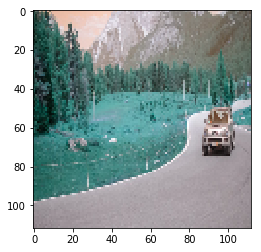

In [8]:
plt.imshow(img)

In [9]:


X_train = np.array(images_train)
X_train = X_train / 255.

y_train = np.array(labels_train)

X_validation = np.array(images_valid)
X_validation = X_validation / 255.

y_validation = np.array(labels_valid)

In [10]:

(X_train.shape, y_train.shape)

((16, 4, 112, 112, 3), (16, 4, 112, 112, 3))

In [11]:
#X = images

In [12]:
def RCL3D_block(filedepth, inpt):
    '''
    recurrent convolution block
    ARGUMENTS: filedepth, int, represents the no of conv filters, input layer is a convolutional neural network layer
    RETURNS stack8, neural net layer
    '''
    conv1 = Conv3D(filters=filedepth, kernel_size=3, strides=(1, 1,1), padding='same',activation='relu')(inpt)
    stack2 = BatchNormalization()(conv1)

    RCL = Conv3D(filters=filedepth, kernel_size=3, strides=(1, 1,1), padding='same', activation='relu')

    conv2 = RCL(stack2)
    stack3 = Add()([conv1, conv2])
    stack4 = BatchNormalization()(stack3)

    conv3 = Conv3D(filters=filedepth, kernel_size=2, strides=(1, 1,1), padding='same',activation='relu')(stack4)
    stack5 =  Add()([conv1, conv3])
    stack6 = BatchNormalization()(stack5)

    conv4 = Conv3D(filters=filedepth, kernel_size=[3, 3,3], strides=(1, 1,1), padding='same',activation='softmax')(stack6)
    stack7 =  Add()([conv1, conv4])
    stack8 = BatchNormalization()(stack7)

    return stack8

In [13]:
def model(t,h,w,c):
    """
    Arguments:

    Returns:
    model -- Keras model instance
    """
    
    #________________________INPUT_________________________________________
    input_brick = Input(shape=(t,h,w,c)) #will be (4,112,112,3)
    
    #________________________ENCODING NETWORK 1_________________________________________
    conv_1e = Conv3D(filters=64,kernel_size=[3,3,3],strides=(1,1,1),padding='same',activation='relu')(input_brick)
    # since padding = same, size is still (4,112,112,3)
    maxpool_1e = MaxPooling3D((2,2,2), strides=(2,2,2), padding='valid')(conv_1e)
    # since padding = valid, size is  (2,56,56,3)
    
    #_______________________DECODING NETWORK 1____________________________________________
    deconv_1d = Conv3DTranspose(filters=1,kernel_size=[3,3,3],strides=(2,2,2),padding='same',
                               activation='relu')(maxpool_1e) #deconv5b-UpSmp in caffe
    # since padding = same, size is (4,112,112,3)
    rconv_1d = RCL3D_block(65, deconv_1d)
    #_______________________Out___________________________________________________________
    out_1 = Conv3D(filters=3,kernel_size=[3,3,3],strides=(1,1,1),padding='same',activation='relu')(rconv_1d)
    
    #________________________ENCODING NETWORK 2_________________________________________
    conv_2e = Conv3D(filters=128,kernel_size=[3,3,3],strides=(1,1,1),padding='same',activation='relu')(maxpool_1e)
    # since padding = same, size is still (2,56,56,3)
    maxpool_2e = MaxPooling3D((2,2,2), strides=(2,2,2), padding='valid')(conv_2e)
    # since padding = valid, size is  (1,28,28,3)
    
    #_______________________DECODING NETWORK 2____________________________________________
    deconv_2d = Conv3DTranspose(filters=1,kernel_size=[3,3,3],strides=(2,2,2),padding='same',
                               activation='relu')(maxpool_2e) #deconv5b-UpSmp in caffe
    # since padding = same, size is (2,56,56,3)
    rconv_2d = RCL3D_block(65, deconv_2d)
    deconv_3d = Conv3DTranspose(filters=1,kernel_size=[3,3,3],strides=(2,2,2),padding='same',
                               activation='relu')(rconv_2d) #deconv5b-UpSmp in caffe
    # since padding = same, size is (4,112,112,3)
    rconv_3d = RCL3D_block(128, deconv_3d)
    
    
    #_______________________Out_______________________filters = 3 for RGB ground thruth
    out_1 = Conv3D(filters=3,kernel_size=[3,3,3],strides=(1,1,1),padding='same',activation='relu')(rconv_1d)
    # since padding = same, size is still (4,112,112,3)
    out_2 = Conv3D(filters=3,kernel_size=[3,3,3],strides=(1,1,1),padding='same',activation='relu')(rconv_3d)
    # since padding = same, size is still (4,112,112,3)


    # Step 3: Create model instance 
    model = Model(inputs=[input_brick], outputs=[out_1,out_2])
    
    return model

In [14]:
model = model(time,height,width,3)

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 4, 112, 112, 3 0                                            
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 4, 112, 112, 6 5248        input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)   (None, 2, 56, 56, 64) 0           conv3d_1[0][0]                   
____________________________________________________________________________________________________
conv3d_7 (Conv3D)                (None, 2, 56, 56, 128 221312      max_pooling3d_1[0][0]            
___________________________________________________________________________________________

In [16]:
SVG(model_to_dot(model).create(prog='dot',format='svg'))
plot_model(model, to_file='model.png')

In [17]:
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy'])

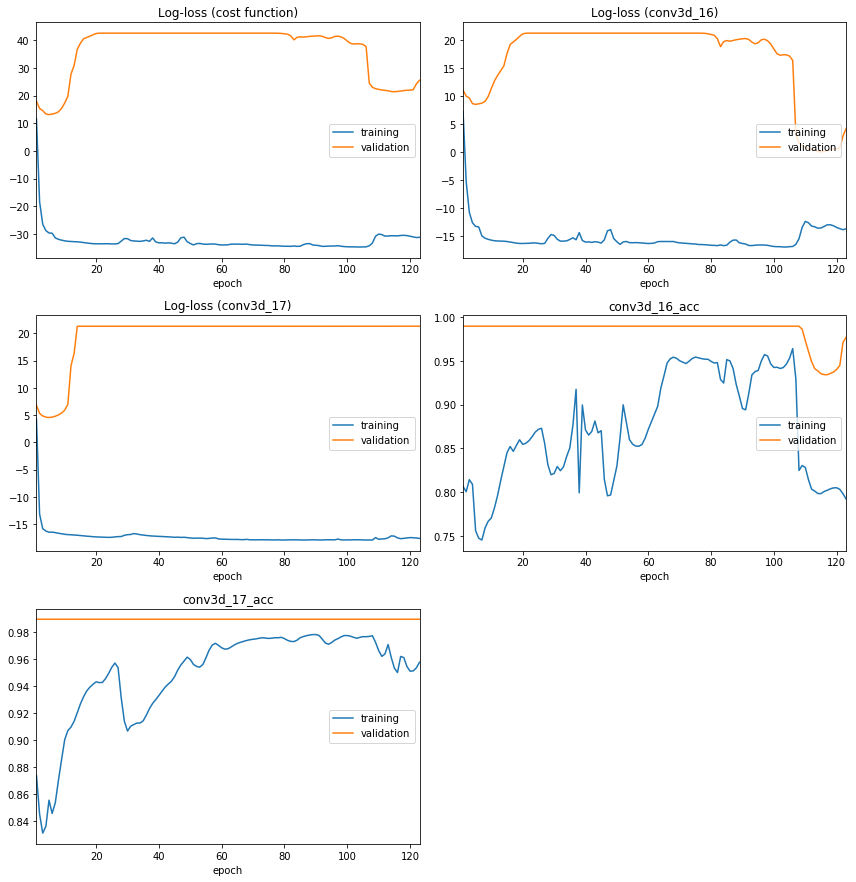

Log-loss (cost function):
training   (min:  -34.749, max:   11.608, cur:  -31.245)
validation (min:   13.157, max:   42.625, cur:   25.586)

Log-loss (conv3d_16):
training   (min:  -16.885, max:    7.308, cur:  -13.637)
validation (min:    0.113, max:   21.313, cur:    4.259)

Log-loss (conv3d_17):
training   (min:  -17.910, max:    4.301, cur:  -17.608)
validation (min:    4.573, max:   21.327, cur:   21.327)

conv3d_16_acc:
training   (min:    0.746, max:    0.964, cur:    0.792)
validation (min:    0.934, max:    0.989, cur:    0.977)

conv3d_17_acc:
training   (min:    0.831, max:    0.978, cur:    0.958)
validation (min:    0.989, max:    0.989, cur:    0.989)


In [18]:
model.fit(X_train,[y_train,y_train], batch_size=8, epochs=123, 
          validation_data=(X_validation,[y_validation,y_validation]),callbacks=[PlotLossesCallback()],verbose=0)

In [19]:
X_test = X_validation[0,:,:,:,:]
y_test = y_validation[0,:,:,:,:]

In [20]:
y_pred = model.predict(X_validation)[1][0,:,:,:,:]

In [21]:
y_pred.shape

(4, 112, 112, 3)

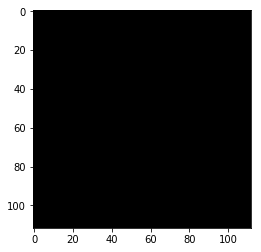

In [22]:
plt.imshow(y_pred[2,:,:,:])

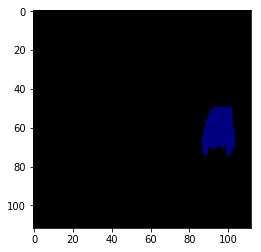

In [23]:
plt.imshow(y_test[2,:,:,:])

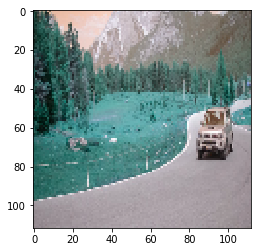

In [24]:
plt.imshow(X_test[2,:,:,:])

In [25]:
(X_test[2,:,:,:].shape , y_pred[2,:,:,:].shape)

((112, 112, 3), (112, 112, 3))

In [26]:
print(X_test[2,:,:,:][60,100,:])
print(y_pred[2,:,:,:][60,100,:] / 255.)

[0.52156863 0.52941176 0.52941176]
[0. 0. 0.]


In [27]:
#plt.imshow(addWeighted(X_test[2,:,:,:], 0.6, y_pred[2,:,:,:] / 255., 0.4, 0.0))

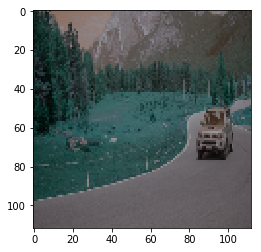

In [28]:
plt.imshow(( 0.6 * X_test[2,:,:,:] + 0.4 * (y_pred[2,:,:,:] )))

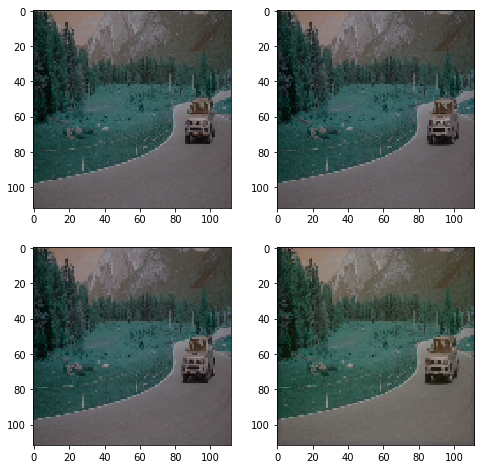

In [29]:
plt.figure(1,figsize=(8,8))
plt.subplot(221)
plt.imshow(( 0.6 * X_test[0,:,:,:] + 0.4 * (y_pred[0,:,:,:] )))

plt.subplot(222)
plt.imshow(( 0.6 * X_test[1,:,:,:] + 0.4 * (y_pred[1,:,:,:] )))

plt.subplot(223)
plt.imshow(( 0.6 * X_test[2,:,:,:] + 0.4 * (y_pred[2,:,:,:] )))

plt.subplot(224)
plt.imshow(( 0.6 * X_test[3,:,:,:] + 0.4 * (y_pred[3,:,:,:] )))

plt.show()

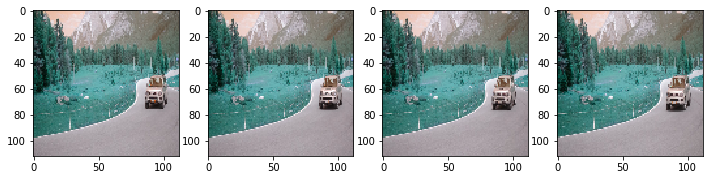

In [30]:
plt.figure(1,figsize=(12,6))
plt.subplot(141)
plt.imshow(X_test[0,:,:,:] )

plt.subplot(142)
plt.imshow( X_test[1,:,:,:])

plt.subplot(143)
plt.imshow( X_test[2,:,:,:])

plt.subplot(144)
plt.imshow( X_test[3,:,:,:] )

plt.show()